## UQR2216 Assignment 1
### Tian Mengxi (e0555841)
An Ordinary Least Squares Multiple Regression model was built by using 9 X-variables to predict the dependent Y-variable ‘room receipt’, after which the RMSE, R^2 and MAE were used as metrics to evaluate the quality of the model’s prediction. 

The following were taken into consideration in this model:
- Categorical variables
- Collinearity
- Transformations
- Feature Selection

In [172]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as pl
%matplotlib inline
from numpy.polynomial.polynomial import polyfit

df = pd.read_excel('Singapore_Hotel.xlsx')
df.columns = df.columns.str.replace(' ','_').str.lower()
print('Dataset has', len(df), 'rows.\n')
print(df.head())

Dataset has 580 rows.

   year  month  days    type  occupancy_rate   room_rate  room_receipt
0  2020      1    31  Luxury       83.478003  506.427381    422.755465
1  2019     12    31  Luxury       86.472915  493.608149    426.837353
2  2019     11    30  Luxury       89.676464  452.747203    406.007682
3  2019     10    31  Luxury       87.985274  457.485963    402.520279
4  2019      9    30  Luxury       88.450824  489.061425    432.578859


## Cleaning Up Data
1. Drop rows with missing values
2. Drop rows with invalid entries. For the numeric columns 'year', 'month', 'days', 'occupancy_rate', 'room_rate' and 'room_receipt', these are rows where the values are negative. 
3. Display the unique values in 'year', 'month', 'days' and 'type' to ensure that all values are valid, before turn these columsn into categorical variables later.

In [173]:
#delete rows with any missing values
df.dropna(how='any', inplace=True)

#delete rows with invalid entries
df = df[(df.days>0) & (df.occupancy_rate>0) & (df.room_rate>0) & (df.room_receipt>0) &
        (df.year>0) & (df.month>0)]

In [174]:
#check that the unique values in year, month, days and type are all valid
print("Unique entries in variable 'year':", sorted(set(df['year'].dropna()))
      + ([np.nan] if df['year'].isnull().sum() > 0 else []))
print("\nUnique entries in variable 'month':", sorted(set(df['month'].dropna()))
      + ([np.nan] if df['month'].isnull().sum() > 0 else []))
print("\nUnique entries in variable 'days':", sorted(set(df['days'].dropna()))
      + ([np.nan] if df['days'].isnull().sum() > 0 else []))
print("\nUnique entries in variable 'type':", sorted(set(df['type'].dropna()))
      + ([np.nan] if df['type'].isnull().sum() > 0 else []))

Unique entries in variable 'year': [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

Unique entries in variable 'month': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

Unique entries in variable 'days': [28, 29, 30, 31]

Unique entries in variable 'type': ['Economy', 'Luxury', 'Mid-Tier', 'Upscale']


## Setting up Dependent Y-Variable as 'room_receipt' and dropping 'room_rate' due to the 'room_receipt ~ room_rate * occupancy_rate' relationship
In this assignment, the dependent Y-variable to be predicted is ‘room receipt’. 

When I previously run the code for interactions and came up with a least squares regression for all variables including the interactions, I discovered that occupancy_rate x room_rate has very high t-value and a P-value of close to 0. This is interesting, and upon closer inspection of the excel data, it appears likely that the room receipt column of the excel data can be very closely approximated by taking the occupancy rate x room rate. Logically, this relationship is also not only reasonable, but also justified. 

As such I have decided to drop 'occupancy_rate' in my analysis. This would allow my model to be trained to predict values for 'room_receipt' without knowledge of the 'occupancy_rate'.

In [175]:
y = 'room_receipt'
#drop 'room_rate' from the dataframe
df.drop('occupancy_rate', axis=1, inplace=True)
#get column names:
colname = list(df)
#move y to position 0:
colname.insert(0, colname.pop(colname.index(y)))
df = df[colname]
print(colname)

['room_receipt', 'year', 'month', 'days', 'type', 'room_rate']


## Categorical Variables
Create categorical variables for 'type', 'year', 'days' and 'month'

In [176]:
#turn text variable Type into categorical dummies
print("\nUnique values in text variable 'type':", sorted(set(df['type'].dropna()))
      + ([np.nan] if df['type'].isnull().sum() > 0 else []))

#use short prefix 't' instead of the obvious 'type' for better printing output
d1 = pd.get_dummies(df['type'], prefix='t', drop_first=True)
d1.rename(columns={'t_Mid-Tier': 't_Midtier'},inplace=True)
print("\nCategorical dummies from text variable 'type':\n")
print(d1.head(3))

#turn numeric variable month into categorical dummies
print("\nUnique values in numeric variable 'month':", sorted(set(df['month'].dropna()))
      + ([np.nan] if df['month'].isnull().sum() > 0 else []))

#use short prefix 'm' instead of the obvious 'month' for better printing output
d2 = pd.get_dummies(df['month'], prefix='m', drop_first=True)

print("\nCategorical dummies from numeric variable 'month':\n")
print(d2.head(3))

#turn numeric variable Year into categorical dummies
print("\nUnique values in numeric variable 'year':", sorted(set(df['year'].dropna()))
      + ([np.nan] if df['year'].isnull().sum() > 0 else []))

#use short prefix 'y' instead of the obvious 'year' for better printing output
d3 = pd.get_dummies(df['year'], prefix='y', drop_first=True)

print("\nCategorical dummies from numeric variable 'year:\n")
print(d3.head(3))

#turn numeric variable Day into categorical dummies
print("Unique values in numeric variable 'days':", sorted(set(df['days'].dropna()))
      + ([np.nan] if df['days'].isnull().sum() > 0 else []))

#use short prefix 'M' instead of the obvious 'Month' for better printing output
d4 = pd.get_dummies(df['days'], prefix='d', drop_first=True)

print("\nCategorical dummies from numeric variable 'days':\n")
print(d4.head(3))


Unique values in text variable 'type': ['Economy', 'Luxury', 'Mid-Tier', 'Upscale']

Categorical dummies from text variable 'type':

   t_Luxury  t_Midtier  t_Upscale
0         1          0          0
1         1          0          0
2         1          0          0

Unique values in numeric variable 'month': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

Categorical dummies from numeric variable 'month':

   m_2  m_3  m_4  m_5  m_6  m_7  m_8  m_9  m_10  m_11  m_12
0    0    0    0    0    0    0    0    0     0     0     0
1    0    0    0    0    0    0    0    0     0     0     1
2    0    0    0    0    0    0    0    0     0     1     0

Unique values in numeric variable 'year': [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

Categorical dummies from numeric variable 'year:

   y_2009  y_2010  y_2011  y_2012  y_2013  y_2014  y_2015  y_2016  y_2017  \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0 

In [177]:
#reconstitute dataframe df:
df = pd.concat([df.drop(['type', 'month', 'year', 'days'], axis=1), d1, d2, d3, d4], axis=1)
print('Reconstituted dataset has', len(df), 'rows.\n')
print(list(df))

Reconstituted dataset has 577 rows.

['room_receipt', 'room_rate', 't_Luxury', 't_Midtier', 't_Upscale', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9', 'm_10', 'm_11', 'm_12', 'y_2009', 'y_2010', 'y_2011', 'y_2012', 'y_2013', 'y_2014', 'y_2015', 'y_2016', 'y_2017', 'y_2018', 'y_2019', 'y_2020', 'd_29', 'd_30', 'd_31']


## Variable Transformation
- square and square-root when variable non-negative
- cube and cube-root for variable with any negative value

In [178]:
#use only a subset of Xs:
df_trans = df[['room_receipt','room_rate']].copy()

#add squares and sqrt of Xs:
for i in list(df_trans)[1:]: 
    if sum(df_trans[i] < 0) == 0: 
        df_trans[i + '_sqar'] = df[i] ** 2 
        df_trans[i + '_sqrt'] = np.sqrt(df[i]) 
    else: 
        df_trans[i + '_cube'] = df[i] ** 3
        df_trans[i + '_cbrt'] = np.cbrt(df[i])

#verify square & square-root: 
print(df_trans.head(3), '\n')

#concatenate transformed variables to the original dataframe df:
df = df.join(df_trans.drop(['room_rate'], axis=1).set_index('room_receipt'), on='room_receipt')
print('Reconstituted dataset has', len(df), 'rows.\n')
print(list(df))

   room_receipt   room_rate  room_rate_sqar  room_rate_sqrt
0    422.755465  506.427381   256468.692180       22.503941
1    426.837353  493.608149   243649.004977       22.217294
2    406.007682  452.747203   204980.029373       21.277857 

Reconstituted dataset has 577 rows.

['room_receipt', 'room_rate', 't_Luxury', 't_Midtier', 't_Upscale', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9', 'm_10', 'm_11', 'm_12', 'y_2009', 'y_2010', 'y_2011', 'y_2012', 'y_2013', 'y_2014', 'y_2015', 'y_2016', 'y_2017', 'y_2018', 'y_2019', 'y_2020', 'd_29', 'd_30', 'd_31', 'room_rate_sqar', 'room_rate_sqrt']


## Checking for collinearity of one raw variable with another raw variable
Delete any raw x too highly correlated with another raw x, to avoid collinearity

In [179]:
corv = pd.DataFrame() #start empty dataframe for corr(Xs, y) to come
for x in list(df)[1:]:
    #during 1st time thru loop, new column, with label, created in empty dataframe
    corv.loc[x, y] = df[x].corr(df[y]) #new entry, with row label, added to dataframe

corv = corv.loc[abs(corv).sort_values([y]).index, :] #corr(Xs, y) ranked

delta = 0.005 #corr difference lower limit
dl2 = []
icorr = True
while icorr:
    a = abs(corv).diff() <= delta #adjacent rows with similar abs(corr(Xs, y))
    colname = list(df)[1:]
    dl = []
    print('\nX pairs with correlations >', 1 - delta, ':')
    for b in range(1, a.shape[0]):
        if a.iloc[b, 0]:
            if abs(df[a.index[b - 1]].corr(df[a.index[b]])) > 1 - delta:
                #deleting 1 X from correlated pair:
                dv0 = a.index[b - 1]
                dv1 = a.index[b]

                #neither should already be deleted:
                if not (dv0 in dl) and not (dv1 in dl):
                    #delete x with rather lower corr(x, y):
                    if abs(corv.loc[dv0, y]) - abs(corv.loc[dv1, y]) >= delta:
                        d = dv1
                    elif len(dv0) < len(dv1): #delete x with longer name:
                        d = dv1
                    else:
                        d = dv0

                    dl.append(d) #for en masse deletion later
                    corv.drop([d], axis=0, inplace=True) #delete from column of corr with y

                    print(dv0,',',dv1)

    if len(dl) > 0:
        df.drop(axis=1, columns=dl, inplace=True) #variables deleted en masse
        dl2 = dl2 + dl #keep for real deletion later
        print('\n' + str(len(dl)), 'variables considered for deletion:')
        print('\n'.join([str(x) for x in dl]))
    else:
        print('(no more)')
        icorr = False

#remaining Xs may be collinear
print('\n' + str(len(dl2)), 'collinear variables deleted.')

#potential collinearity issues handled


X pairs with correlations > 0.995 :
(no more)

0 collinear variables deleted.


## Feature Selection
Perform feature selection using adjusted R2 after transformation.

In [180]:
#t-stat p-value kept below .05
df0 = df.copy()
df3 = df.copy()
modeleq = ' + '.join(list(df3)).replace('+', '~', 1)
print(modeleq)
maxR2 = -np.inf
bmodeleq = modeleq
R205 = -np.inf
modeleq05 = ''
numx = df3.shape[1] - 1
from statsmodels.formula.api import ols

while True:
    regout = ols(modeleq, df3).fit()
    R2 = regout.rsquared_adj
    maxp = max(regout.pvalues[1:])
    #see if a better model is found:
    if R2 > maxR2:
        maxR2 = R2
        bmodeleq = modeleq
        if maxp >= 0.05:
            #reset p-value criterion:
            R205 = -np.inf
            modeleq05 = ''
    
    #see if a better model is found with max(t-stat p-value) < .05:
    if maxp < .05 and R2 > R205:
        R205 = R2
        modeleq05 = modeleq
        
    print('\nAdjusted R2 =', R2, '  &   max(p-value) =', maxp, '  for', numx, 'Xs.')

    if numx == 1:
        print('Variable left:', modeleq[modeleq.find('~') + 2 :])
        # 1 xvar left
        break

    #identify X variable to delete by finding the one with smallest abs(t-stat):
    t = regout.tvalues[1:]
    xdrop = list(t[abs(t) == min(abs(t))].index)[0]
    print('Variable to drop:', xdrop)
    
    df3.drop(xdrop, axis=1, inplace=True)
    modeleq = ' + '.join(list(df3)).replace('+', '~', 1)
    
    numx = numx - 1

#see if best model with all t-stat p-values < 0.05 is smaller than best model by adjusted R2:
if R205 > -np.inf and len(modeleq05) < len(bmodeleq):
    bmodeleq = modeleq05

numx = bmodeleq.count('+') + 1
print('\nBest model has', numx, 'Xs:')
regout = ols(bmodeleq, df0).fit()
print(regout.summary2())

if numx > 1:
    #construct and print the variables in order of importance:

    print("\nX-coefficients' |t-stats| ranked:\n")
    c = pd.Series(regout.params.index, index=regout.params.index)
    df2 = pd.concat([c, regout.params, regout.tvalues, regout.pvalues, abs(regout.tvalues)], axis=1
                   ).iloc[1:, :].sort_values(4, ascending=False).iloc[:, :4] #sort by 5th (4) column
    df2.columns = ['', 'Coefficient', 't-stat', 'P>|t|']
    df2.index = np.arange(1, len(df2) + 1)
    print(df2)

room_receipt ~ room_rate + t_Luxury + t_Midtier + t_Upscale + m_2 + m_3 + m_4 + m_5 + m_6 + m_7 + m_8 + m_9 + m_10 + m_11 + m_12 + y_2009 + y_2010 + y_2011 + y_2012 + y_2013 + y_2014 + y_2015 + y_2016 + y_2017 + y_2018 + y_2019 + y_2020 + d_29 + d_30 + d_31 + room_rate_sqar + room_rate_sqrt

Adjusted R2 = 0.9919817317717686   &   max(p-value) = 0.942336892579906   for 32 Xs.
Variable to drop: m_5

Adjusted R2 = 0.9919963136319011   &   max(p-value) = 0.8055702304365819   for 31 Xs.
Variable to drop: y_2020

Adjusted R2 = 0.9920100331483246   &   max(p-value) = 0.69695528703099   for 30 Xs.
Variable to drop: d_29

Adjusted R2 = 0.992022377310482   &   max(p-value) = 0.6924031397432802   for 29 Xs.
Variable to drop: t_Midtier

Adjusted R2 = 0.9920346097463375   &   max(p-value) = 0.3911715873689622   for 28 Xs.
Variable to drop: m_9

Adjusted R2 = 0.9920346097463375   &   max(p-value) = 0.09814946315094766   for 27 Xs.
Variable to drop: y_2009

Adjusted R2 = 0.9920093883552589   &   max(

## Combining some dummy variables from 'month', and 'year', and dropping transformed variables for 'room_rate'.
- Since the transformed variables for 'room_rate' ranked higher in p-value than the raw, untransformed variable, I decided to drop the transformed one.
- To decrease the number of X-variables, I decided to adopt a new model with fewer dummy variables by combining some of them together, testing to see whether the t-stat value for the top ranked variables increases. It did. 

In [185]:
#perform feature selection using adjusted R2 after transformation
#t-stat p-value kept below .05
df3 = df.drop(['room_rate_sqrt', 'room_rate_sqar', 'y_2020', 'y_2018', 'y_2016', 'y_2014',
               'y_2012', 'y_2010', 'm_2',  'm_3',  'm_5',  'm_6',  'm_8',  'm_9', 'm_11'], axis=1)

print('Initial variables included before feature selection:')
print(list(d3))
modeleq = ' + '.join(list(df3)).replace('+', '~', 1)
print(modeleq)
maxR2 = -np.inf
bmodeleq = modeleq
R205 = -np.inf
modeleq05 = ''
numx = df3.shape[1] - 1
from statsmodels.formula.api import ols

while True:
    regout = ols(modeleq, df3).fit()
    R2 = regout.rsquared_adj
    maxp = max(regout.pvalues[1:])
    #see if a better model is found:
    if R2 > maxR2:
        maxR2 = R2
        bmodeleq = modeleq
        if maxp >= 0.05:
            #reset p-value criterion:
            R205 = -np.inf
            modeleq05 = ''
    
    #see if a better model is found with max(t-stat p-value) < .05:
    if maxp < .05 and R2 > R205:
        R205 = R2
        modeleq05 = modeleq
        
    print('\nAdjusted R2 =', R2, '  &   max(p-value) =', maxp, '  for', numx, 'Xs.')

    if numx == 1:
        print('Variable left:', modeleq[modeleq.find('~') + 2 :])
        # 1 xvar left
        break

    #identify X variable to delete by finding the one with smallest abs(t-stat):
    t = regout.tvalues[1:]
    xdrop = list(t[abs(t) == min(abs(t))].index)[0]
    print('Variable to drop:', xdrop)
    
    df3.drop(xdrop, axis=1, inplace=True)
    modeleq = ' + '.join(list(df3)).replace('+', '~', 1)
    
    numx = numx - 1

#see if best model with all t-stat p-values < 0.05 is smaller than best model by adjusted R2:
if R205 > -np.inf and len(modeleq05) < len(bmodeleq):
    bmodeleq = modeleq05

numx = bmodeleq.count('+') + 1
print('\nBest model has', numx, 'Xs:')
regout = ols(bmodeleq, df0).fit()
print(regout.summary2())

if numx > 1:
    #construct and print the variables in order of importance:

    print("\nX-coefficients' |t-stats| ranked:\n")
    c = pd.Series(regout.params.index, index=regout.params.index)
    df2 = pd.concat([c, regout.params, regout.tvalues, regout.pvalues, abs(regout.tvalues)], axis=1
                   ).iloc[1:, :].sort_values(4, ascending=False).iloc[:, :4] #sort by 5th (4) column
    df2.columns = ['', 'Coefficient', 't-stat', 'P>|t|']
    df2.index = np.arange(1, len(df2) + 1)
    print(df2)

Initial variables included before feature selection:
['y_2009', 'y_2010', 'y_2011', 'y_2012', 'y_2013', 'y_2014', 'y_2015', 'y_2016', 'y_2017', 'y_2018', 'y_2019', 'y_2020']
room_receipt ~ room_rate + t_Luxury + t_Midtier + t_Upscale + m_4 + m_7 + m_10 + m_12 + y_2009 + y_2011 + y_2013 + y_2015 + y_2017 + y_2019 + d_29 + d_30 + d_31

Adjusted R2 = 0.9889858079038928   &   max(p-value) = 0.8989330405263941   for 17 Xs.
Variable to drop: m_4

Adjusted R2 = 0.9890051585407188   &   max(p-value) = 0.6666329435471623   for 16 Xs.
Variable to drop: y_2011

Adjusted R2 = 0.9890211164944795   &   max(p-value) = 0.49926353803934564   for 15 Xs.
Variable to drop: m_10

Adjusted R2 = 0.9890317223562871   &   max(p-value) = 0.21363556173223341   for 14 Xs.
Variable to drop: y_2015

Adjusted R2 = 0.9890210048654166   &   max(p-value) = 0.15684723075784227   for 13 Xs.
Variable to drop: d_31

Adjusted R2 = 0.9890013493255314   &   max(p-value) = 0.19715708287814038   for 12 Xs.
Variable to drop: d_2

Keeping in mind that using too many independent variables may make it difficult to explain the significance of specific variables in the model, I decided use the top 9 variables with the highest t-stats values for the final model:

In [184]:
df5 = df2[''][:-2] #list of all the Xs that will be used to train the model
print(list(df5))

['room_rate', 't_Luxury', 't_Upscale', 'm_7', 'm_12', 'y_2019', 't_Midtier', 'y_2009', 'd_30']


## Splitting into training (3/4) and testing (1/4) data

In [156]:
print(list(df5))
y = df.loc[:, 'room_receipt'].values
X = df.loc[:, list(df5)].values

from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn import metrics
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=1)
#splitting data into test and train

['room_rate', 't_Luxury', 't_Upscale', 'm_7', 'm_12', 'y_2019', 't_Midtier', 'y_2009', 'd_30']


## Training the model and predicting based on testing data

In [157]:
model = linear_model.LinearRegression()
model.fit(Xtr, ytr)
#fitting model with training data
predictions = model.predict(Xte)
#predicting with model and test data

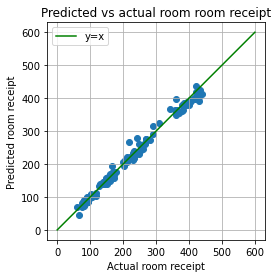

In [158]:
pl.scatter(y=predictions, x=yte)
pl.title('Predicted vs actual room room receipt')
pl.ylabel('Predicted room receipt')
pl.xlabel('Actual room receipt')

lineStart = 0
lineEnd = 600
pl.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-', color = 'g', label='y=x')
pl.xlim(lineStart, lineEnd)
pl.ylim(lineStart, lineEnd)
pl.axis('square')
pl.grid()
pl.legend(loc='upper left')
pl.rcParams["figure.figsize"] = [6.000, 6.145] # for square plot

Find the coefficients corresponding to each variable included in the model:

In [159]:
coefficients = pd.concat([pd.DataFrame(df5.reset_index()),pd.DataFrame(np.transpose(model.coef_))], axis = 1)
#concatenate the columns from panda dataframe with coefficients from model
print('Coefficients: \n', coefficients.to_string(index=False, header=None))

Coefficients: 
 1 room_rate   1.015218
2  t_Luxury -55.919560
3 t_Upscale -22.061815
4       m_7  10.718694
5      m_12  -8.132801
6    y_2019   7.237425
7 t_Midtier  -6.354859
8    y_2009  -8.301015
9      d_30  -2.553163


## Computing R^2, RMSE and MAE values for the predictions

In [160]:
print('\nRoot Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yte, predictions)))
print('R^2:', metrics.r2_score(yte, predictions))
print('MAE:', metrics.median_absolute_error(yte, predictions))


Root Mean Squared Error: 11.349760060133516
R^2: 0.9892032183767624
MAE: 5.539340945318372


## Report on Findings

Overall, the R^2 value of 0.989 means that 98.9% percent of the dependent variable variation can be explained by the model; whether this is satisfactory depends on the client's target accuracy for the predictive model.
 
However, considering that RMSE has the same unit as the dependent variable ‘room_receipt’ (which varies from 52 to 454), the RMSE of 11.35 for the model is high. Furthermore, while the MAE is weights all the errors equally, the RMSE gives a higher weight to larger errors. Thus, comparing the RMSE value with the MAE value of 5.54, we see that the regression does not account for some relatively large errors, and could be improved in terms of its accuracy. 

Finally, the number of x-variables in the model could be further reduced to facilitate ease of interpretation and to further increase its explanability. In the current model, room_rate and t_Luxury have the largest absolute t-statistic values (53.50 and 10.19 respectively), suggesting that they are the most "useful" variables in predicting room_rate. (162 words)